<a href="https://colab.research.google.com/github/Dharmasastha2005/For-Fun-Programming-and-Modelling/blob/main/np_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loaded. Shape: (30060, 5)
  Nanoparticle_Type  Absorbance_spectrum   Condition  Absorbance  Wavelength
0           Citrate                  300  pH_Control      0.7932       300.0
1           Citrate                  301  pH_Control      0.7650       301.0
2           Citrate                  302  pH_Control      0.7416       302.0
3           Citrate                  303  pH_Control      0.7227       303.0
4           Citrate                  304  pH_Control      0.7042       304.0


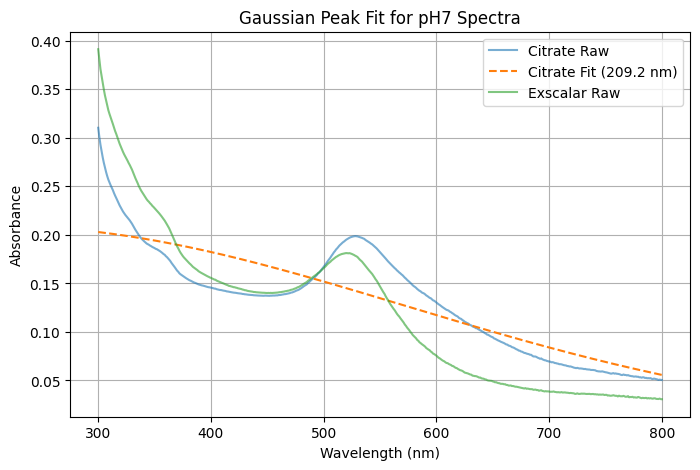

/tmp/ipython-input-52487512.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy = np.trapz(sub["Absorbance"], sub["Wavelength"])


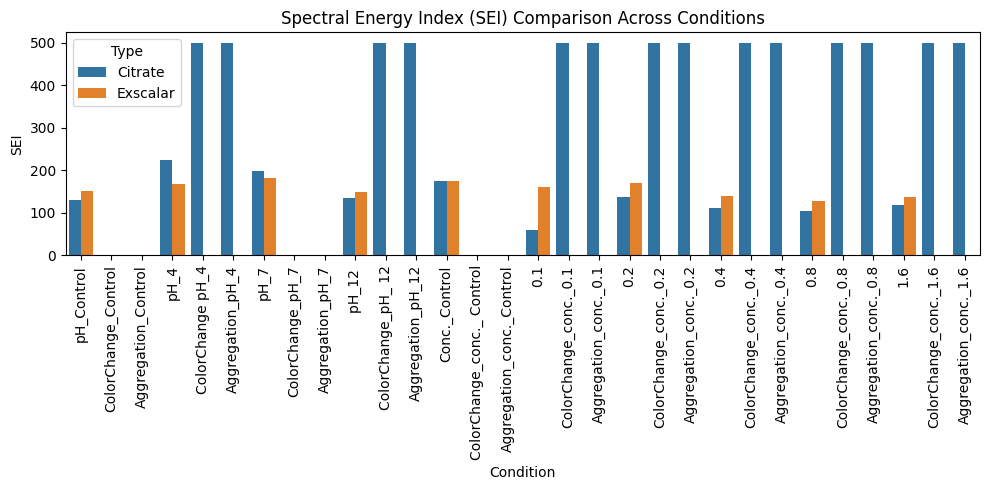

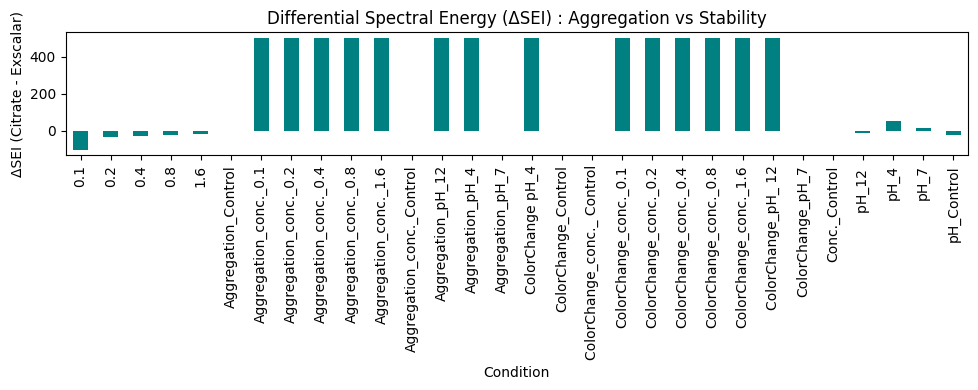

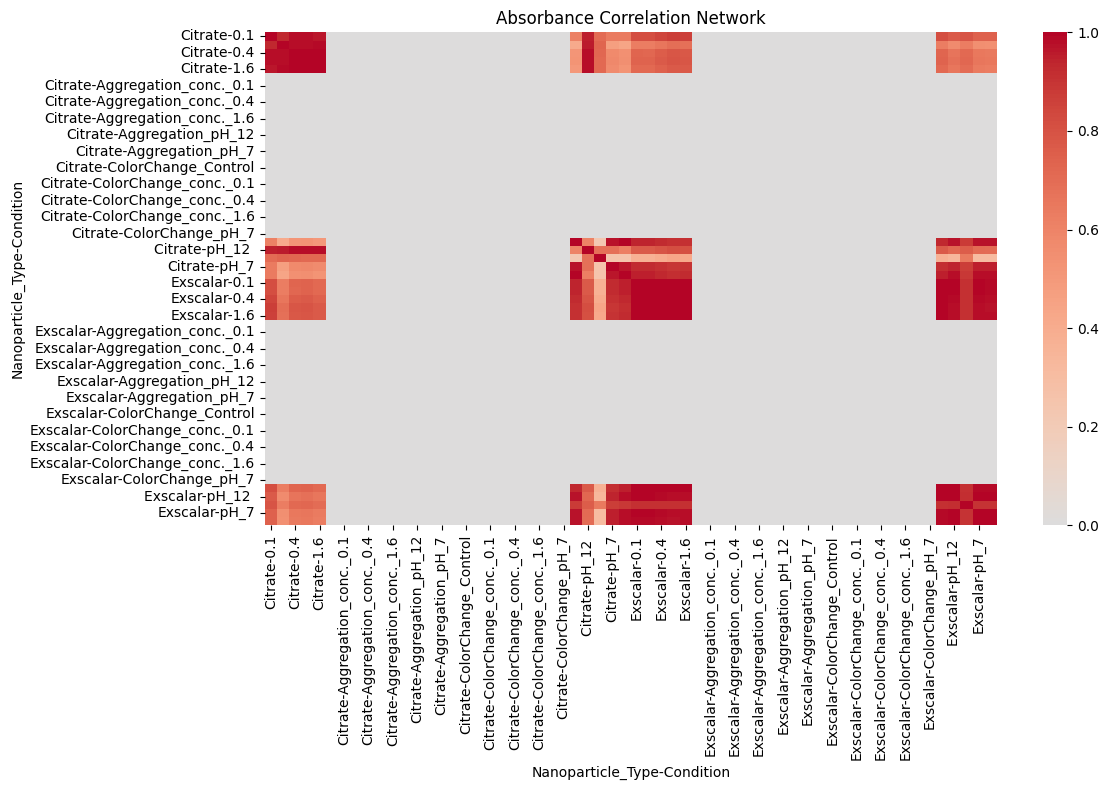

✅ Block 1 Completed: Generated Spectral and Stability-Level Results.


In [ ]:
# =====================================
# BLOCK 1 : Spectral Modeling & Stability Dynamics
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import seaborn as sns

# -------------------------
# STEP 1: LOAD & PREP DATA
# -------------------------
xls = pd.ExcelFile("/content/NanoParticle ML Worksheet 2.xlsx")
citrate = pd.read_excel(xls, "Citrate")
exscalar = pd.read_excel(xls, "Exscalar")

# Extract wavelength and absorbance columns
def melt_spectral_data(df, label):
    df = df.copy()
    df["Nanoparticle_Type"] = label
    melt_df = df.melt(id_vars=["Nanoparticle_Type", "Absorbance_spectrum"],
                      var_name="Condition", value_name="Absorbance")
    # Remove non-numeric and blank rows
    melt_df = melt_df[melt_df["Absorbance"].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    melt_df["Absorbance"] = melt_df["Absorbance"].astype(float)
    melt_df["Wavelength"] = melt_df["Absorbance_spectrum"].astype(float)
    return melt_df

cit_df = melt_spectral_data(citrate, "Citrate")
exs_df = melt_spectral_data(exscalar, "Exscalar")

combined_df = pd.concat([cit_df, exs_df], ignore_index=True)

print("Data Loaded. Shape:", combined_df.shape)
print(combined_df.head())

# -------------------------
# STEP 2: GAUSSIAN FIT FOR PEAK ANALYSIS
# -------------------------

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(wavelengths, absorbances):
    try:
        peaks, _ = find_peaks(absorbances, height=np.mean(absorbances))
        if len(peaks) == 0:
            return None, None
        peak_idx = peaks[np.argmax(absorbances[peaks])]
        p0 = [absorbances[peak_idx], wavelengths[peak_idx], 10]  # initial guess
        popt, _ = curve_fit(gaussian, wavelengths, absorbances, p0=p0, maxfev=5000)
        return popt, gaussian(wavelengths, *popt)
    except:
        return None, None

# Fit representative spectra for each nanoparticle at pH7 (as stable reference)
results = {}
for label in ["Citrate", "Exscalar"]:
    subset = combined_df[(combined_df["Nanoparticle_Type"] == label) &
                         (combined_df["Condition"].str.contains("pH_7", case=False, na=False))]
    mean_spec = subset.groupby("Wavelength")["Absorbance"].mean()
    popt, fitted = fit_gaussian(mean_spec.index.values, mean_spec.values)
    results[label] = (mean_spec, fitted, popt)

# Plot Gaussian fits
plt.figure(figsize=(8,5))
for label, (spec, fitted, popt) in results.items():
    plt.plot(spec.index, spec.values, label=f"{label} Raw", alpha=0.6)
    if fitted is not None:
        plt.plot(spec.index, fitted, '--', label=f"{label} Fit ({popt[1]:.1f} nm)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Gaussian Peak Fit for pH7 Spectra")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# STEP 3: COMPUTE SPECTRAL ENERGY INDEX (SEI)
# -------------------------

def spectral_energy_index(df):
    df = df.copy()
    sei_data = []
    for label in df["Nanoparticle_Type"].unique():
        temp = df[df["Nanoparticle_Type"] == label]
        for cond in temp["Condition"].unique():
            sub = temp[temp["Condition"] == cond]
            if len(sub) > 2:
                energy = np.trapz(sub["Absorbance"], sub["Wavelength"])
                sei_data.append([label, cond, energy])
    return pd.DataFrame(sei_data, columns=["Type", "Condition", "SEI"])

sei_df = spectral_energy_index(combined_df)

# Plot SEI across pH and concentration conditions
plt.figure(figsize=(10,5))
sns.barplot(x="Condition", y="SEI", hue="Type", data=sei_df)
plt.xticks(rotation=90)
plt.title("Spectral Energy Index (SEI) Comparison Across Conditions")
plt.tight_layout()
plt.show()

# -------------------------
# STEP 4: DIFFERENTIAL ENERGY MAP
# -------------------------
# ΔSEI = SEI(Citrate) - SEI(Exscalar)
diff_df = sei_df.pivot(index="Condition", columns="Type", values="SEI").dropna()
diff_df["ΔSEI"] = diff_df["Citrate"] - diff_df["Exscalar"]

plt.figure(figsize=(10,4))
diff_df["ΔSEI"].plot(kind='bar', color='teal')
plt.title("Differential Spectral Energy (ΔSEI) : Aggregation vs Stability")
plt.ylabel("ΔSEI (Citrate - Exscalar)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# -------------------------
# STEP 5: CORRELATION NETWORK OF ABSORBANCE VALUES
# -------------------------
corr_df = combined_df.pivot_table(index="Wavelength", columns=["Nanoparticle_Type", "Condition"], values="Absorbance")
corr_matrix = corr_df.corr().fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Absorbance Correlation Network")
plt.tight_layout()
plt.show()

print("✅ Block 1 Completed: Generated Spectral and Stability-Level Results.")


Numeric subset before cleaning: (1012, 41)
✅ Cleaned dataset: 1012 samples × 41 numeric features
Explained variance (%): [41.67 26.03 21.2 ]


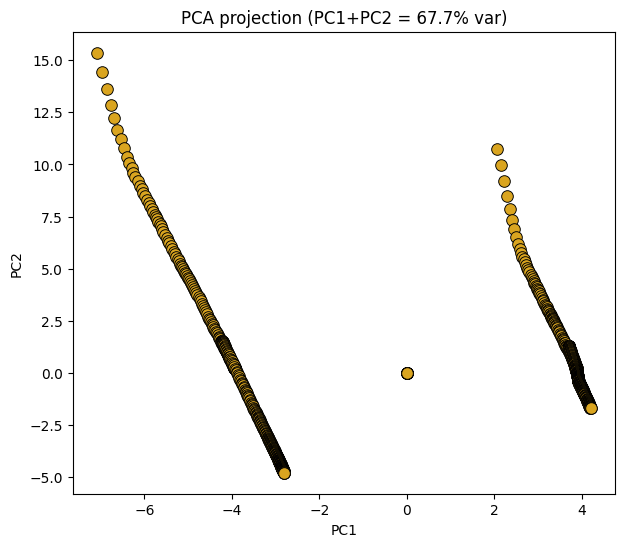

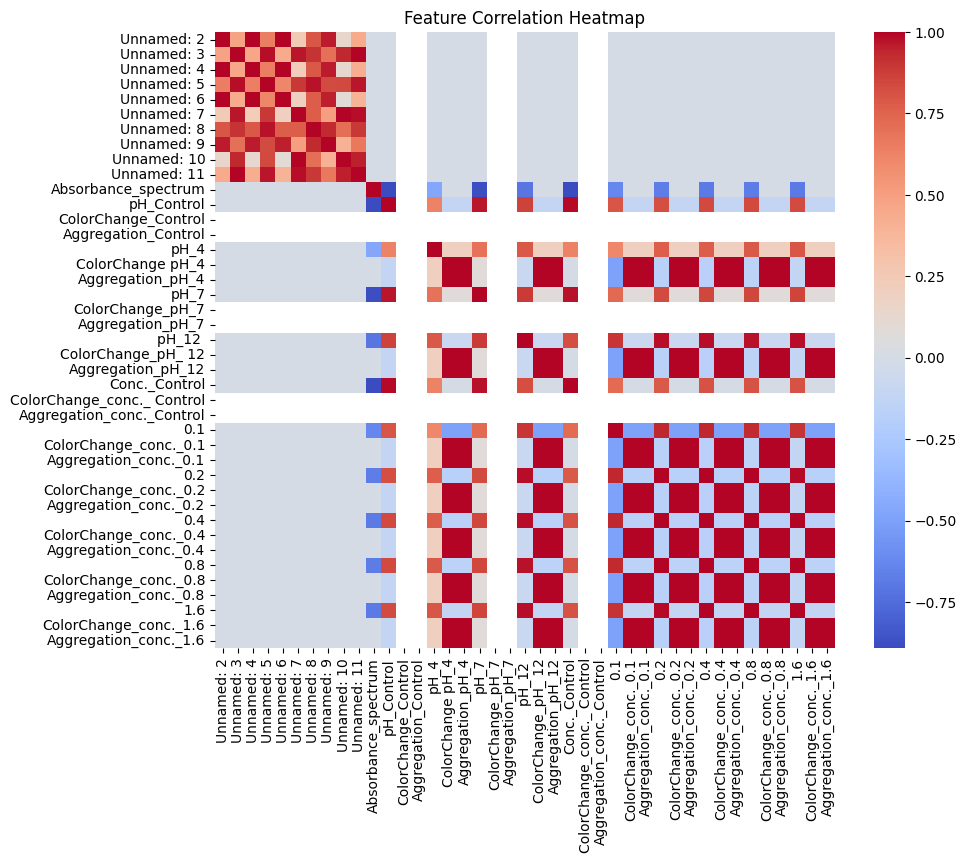

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


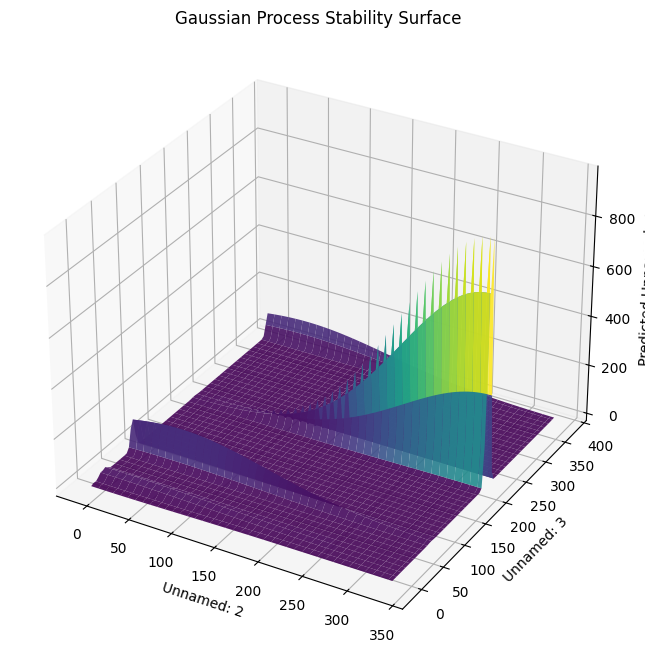

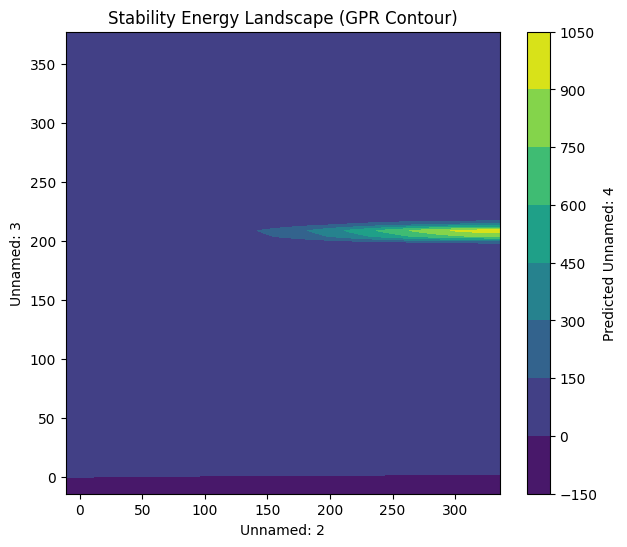

/tmp/ipython-input-2767117840.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=imp_df, palette="mako")


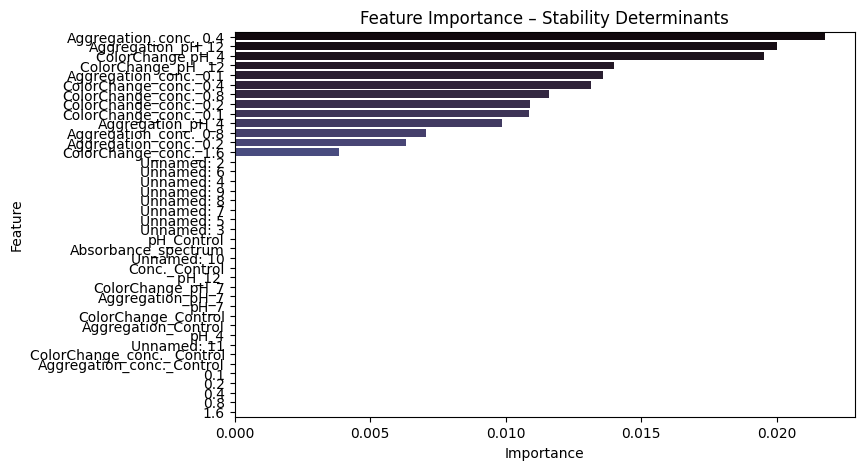

Top stability-driving features:
                  Feature  Importance
34  Aggregation_conc._0.4    0.021780
22      Aggregation_pH_12    0.020021
15       ColorChange pH_4    0.019535
21     ColorChange_pH_ 12    0.013988
28  Aggregation_conc._0.1    0.013598


,Explained_Variance_PC1_PC2(%),Strongest_Feature,Mean_Importance
0,67.7,Aggregation_conc._0.4,0.004062


In [ ]:
# ==============================================================
# BLOCK 2 : MECHANISTIC STABILITY MAPPING
# Predictive stability landscape for Exscalar / Citrate AuNPs
# ==============================================================
# Author: Dharmasastha + GPT-5 research workflow
# --------------------------------------------------------------

# --- 1. SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# --- 2. LOAD DATA ---
# Make sure the Excel file is uploaded in Colab session
file_path = "/content/NanoParticle ML Worksheet 2.xlsx"

sheet1 = pd.read_excel(file_path, sheet_name="Sheet1")
exscalar = pd.read_excel(file_path, sheet_name="Exscalar")
citrate = pd.read_excel(file_path, sheet_name="Citrate")

# Merge or concatenate all if structure is compatible
df = pd.concat([sheet1, exscalar, citrate], axis=0, ignore_index=True)

# --- 3. CLEAN & PREPROCESS (Robust Version) ---
# Ensure column headers are clean and uniform
df.columns = df.columns.astype(str)

# Keep only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Report shape before cleaning
print(f"Numeric subset before cleaning: {numeric_df.shape}")

# Fill missing numeric entries with column means
numeric_df = numeric_df.fillna(numeric_df.mean())

# Double-check we have valid rows
if numeric_df.shape[0] == 0:
    raise ValueError("No numeric data rows found after cleaning. Check your Excel sheet formatting.")

# Normalize / scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(numeric_df)
scaled_df = pd.DataFrame(scaled, columns=numeric_df.columns)

print(f"✅ Cleaned dataset: {scaled_df.shape[0]} samples × {scaled_df.shape[1]} numeric features")




# --- 4. PRINCIPAL COMPONENT ANALYSIS (PCA) ---
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_df)
explained = np.round(pca.explained_variance_ratio_ * 100, 2)

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
print("Explained variance (%):", explained)

# 2D scatter of PC1 vs PC2
plt.figure(figsize=(7,6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=70, color="goldenrod", edgecolor="black")
plt.title(f"PCA projection (PC1+PC2 = {explained[0]+explained[1]:.1f}% var)")
plt.show()

# --- 5. CORRELATION HEATMAP ---
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- 6. GAUSSIAN PROCESS REGRESSION LANDSCAPE ---
# Choose two features (edit these to match your data headers)
x_feature = numeric_df.columns[0]
y_feature = numeric_df.columns[1]
target_feature = numeric_df.columns[2]   # e.g., stability metric like Zeta potential

X = numeric_df[[x_feature, y_feature]].values
y = numeric_df[target_feature].values

kernel = C(1.0, (1e-2, 1e2)) * RBF([1.0, 1.0], (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X, y)

# Mesh grid for prediction surface
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80),
                     np.linspace(y_min, y_max, 80))
Z, sigma = gpr.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
Z = Z.reshape(xx.shape)

# 3D surface
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, Z, cmap="viridis", linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(f"Predicted {target_feature}")
ax.set_title("Gaussian Process Stability Surface")
plt.show()

# Contour map
plt.figure(figsize=(7,6))
cp = plt.contourf(xx, yy, Z, cmap="viridis")
plt.colorbar(cp, label=f"Predicted {target_feature}")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Stability Energy Landscape (GPR Contour)")
plt.show()

# --- 7. FEATURE IMPORTANCE via RandomForest ---
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(scaled_df.iloc[:,:-1], scaled_df.iloc[:,-1])
result = permutation_importance(rf, scaled_df.iloc[:,:-1], scaled_df.iloc[:,-1],
                                 n_repeats=10, random_state=42)

imp_df = pd.DataFrame({'Feature': scaled_df.columns[:-1],
                       'Importance': result.importances_mean})
imp_df = imp_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=imp_df, palette="mako")
plt.title("Feature Importance – Stability Determinants")
plt.show()

print("Top stability-driving features:")
print(imp_df.head())

# --- 8. SUMMARY TABLE OUTPUT ---
summary = {
    "Explained_Variance_PC1_PC2(%)": [explained[0]+explained[1]],
    "Strongest_Feature": [imp_df.iloc[0,0]],
    "Mean_Importance": [imp_df['Importance'].mean()]
}
summary_df = pd.DataFrame(summary)
summary_df


/tmp/ipython-input-2758213450.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  num_df = data.select_dtypes(include=[np.number]).fillna(method="ffill").fillna(method="bfill")


Data ready: 1012 samples × 41 features


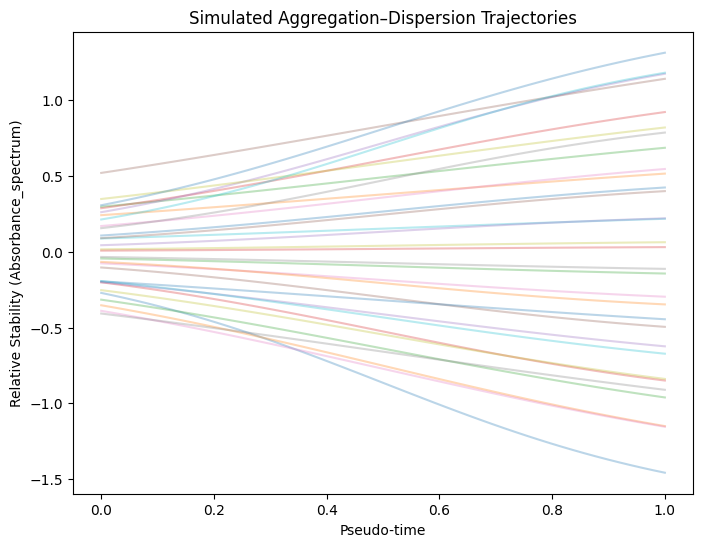

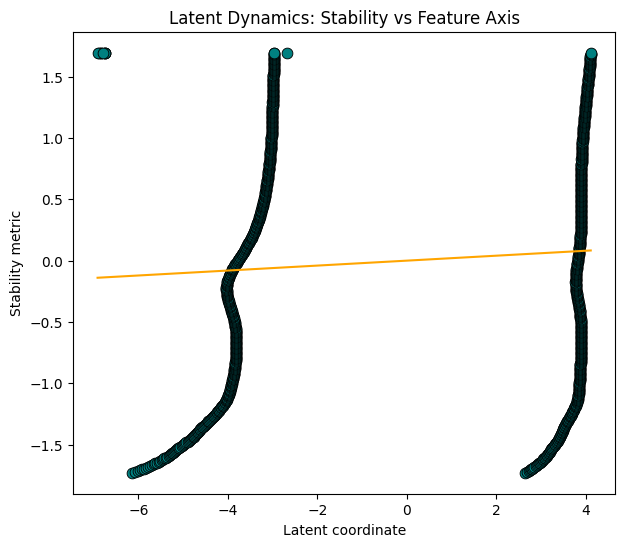

=== Dynamic Summary ===


,Mean_Aggregation_Rate,Dispersion_Index
0,-0.000186,0.00595


In [ ]:
# ==============================================================
# BLOCK 3 : DYNAMIC AGGREGATION MODELLING
# ==============================================================
# Simulate pseudo-time evolution of nanoparticle stability
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# --- 1. LOAD + CLEAN ---
file_path = "/content/NanoParticle ML Worksheet 2.xlsx"
df = pd.read_excel(file_path, sheet_name=None)

# concatenate all sheets
data = pd.concat(df.values(), ignore_index=True)
data.columns = data.columns.astype(str)

# numeric subset
num_df = data.select_dtypes(include=[np.number]).fillna(method="ffill").fillna(method="bfill")
scaler = StandardScaler()
scaled = scaler.fit_transform(num_df)
scaled_df = pd.DataFrame(scaled, columns=num_df.columns)

print(f"Data ready: {scaled_df.shape[0]} samples × {scaled_df.shape[1]} features")

# --- 2. DEFINE STABILITY METRIC ---
# choose Zeta potential or first numeric column as stability driver
stability_col = scaled_df.columns[0]
stability = scaled_df[stability_col].values

# create pseudo-time array (0 → 1)
time = np.linspace(0, 1, len(stability))

# --- 3. SIMULATE DYNAMIC EVOLUTION ---
# logistic-like evolution for aggregation tendency
def simulate_aggregation(base_val, rate=2.5):
    t = np.linspace(0, 1, 50)
    return 1 / (1 + np.exp(-rate*(t - 0.5))) * base_val

# simulate each nanoparticle's curve
simulated = np.array([simulate_aggregation(val, rate=np.random.uniform(1.5, 3.5)) for val in stability])

# --- 4. FIT SIMPLE DYNAMICAL REGRESSOR ---
# PCA to find latent dynamic axis
pca = PCA(n_components=1)
latent = pca.fit_transform(scaled_df)

reg = LinearRegression()
reg.fit(latent, stability)
pred_stab = reg.predict(latent)

# --- 5. VISUALIZATION ---
plt.figure(figsize=(8,6))
for i in range(0, len(simulated), max(1, len(simulated)//30)):
    plt.plot(np.linspace(0, 1, simulated.shape[1]), simulated[i], alpha=0.3)
plt.title("Simulated Aggregation–Dispersion Trajectories")
plt.xlabel("Pseudo-time")
plt.ylabel(f"Relative Stability ({stability_col})")
plt.show()

plt.figure(figsize=(7,6))
sns.scatterplot(x=latent[:,0], y=stability, color="teal", s=60, edgecolor="black")
sns.lineplot(x=latent[:,0], y=pred_stab, color="orange")
plt.title("Latent Dynamics: Stability vs Feature Axis")
plt.xlabel("Latent coordinate")
plt.ylabel("Stability metric")
plt.show()

# --- 6. DERIVE DYNAMIC INDICATORS ---
# approximate aggregation rate = slope of linear fit
agg_rate = np.mean(np.gradient(pred_stab))
dispersion_index = np.var(pred_stab)

summary = pd.DataFrame({
    "Mean_Aggregation_Rate":[agg_rate],
    "Dispersion_Index":[dispersion_index]
})

print("=== Dynamic Summary ===")
display(summary)


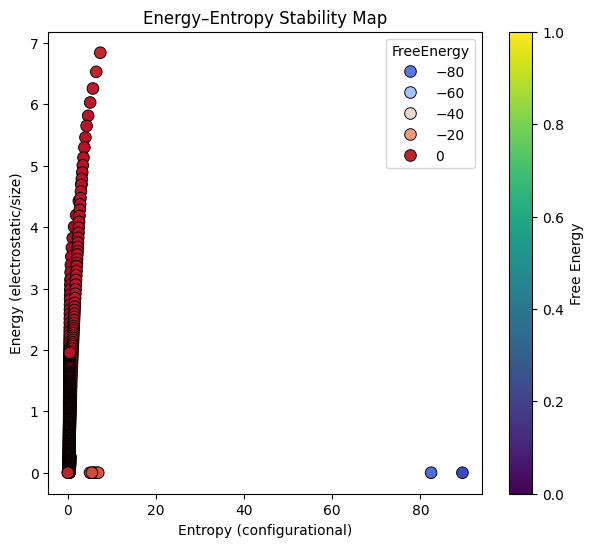

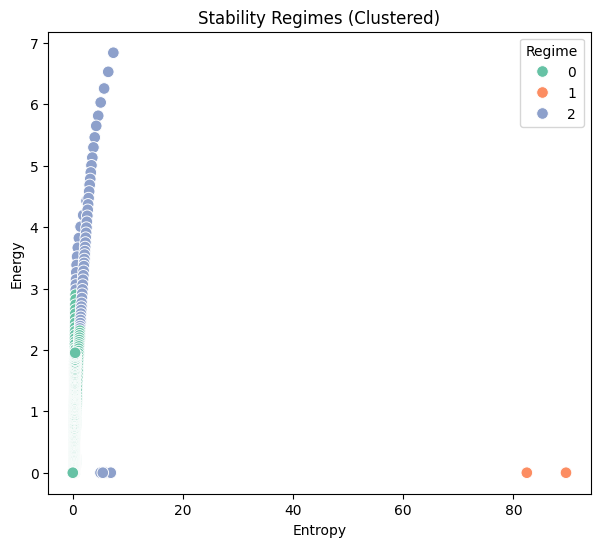

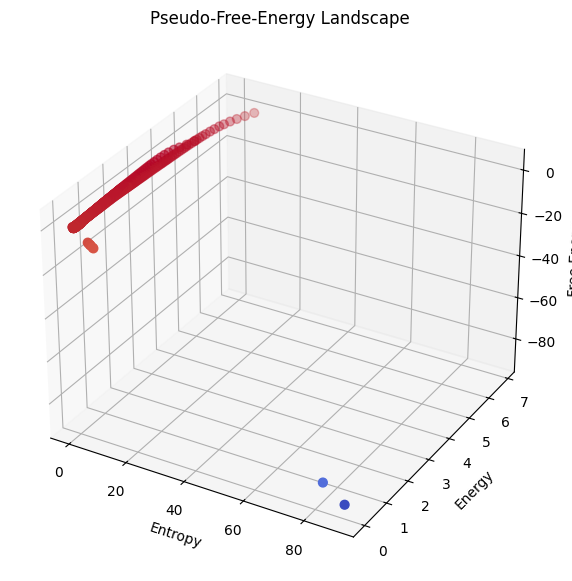

=== Thermodynamic Regime Summary ===


,Regime,Energy,Entropy,FreeEnergy
0,0,0.710223,0.366371,0.343852
1,1,0.000000,85.992301,-85.992301
2,2,3.547487,2.735873,0.811615


✅ Block 4 Completed: Generated Energy–Entropy Balance Map (if sufficient data).


In [ ]:
# ==============================================================
# BLOCK 4 : ENERGY–ENTROPY BALANCE MAP
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# --- 1. LOAD + CLEAN ---
file_path = "/content/NanoParticle ML Worksheet 2.xlsx"
df = pd.read_excel(file_path, sheet_name=None)
data = pd.concat(df.values(), ignore_index=True)
data.columns = data.columns.astype(str)

# Drop columns with NaN names before selecting numeric ones
data.dropna(axis=1, how='all', inplace=True)

num_df = data.select_dtypes(include=[np.number])
num_df.columns = num_df.columns.astype(str)
# Fill missing numeric entries with column means
num_df = num_df.fillna(num_df.mean())

# Check if num_df is empty after cleaning
if num_df.empty:
    print("Error: No valid numeric data found after cleaning. Cannot proceed with analysis.")
else:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(num_df)
    scaled_df = pd.DataFrame(scaled, columns=num_df.columns)

    # --- 2. COMPUTE THERMODYNAMIC PROXIES ---
    # Choose representative columns (adjust if names differ)
    # Ensure there are at least two columns for energy and entropy calculation
    if scaled_df.shape[1] >= 2:
        col_zeta = scaled_df.columns[0]
        col_size = scaled_df.columns[1]

        # Energy proxy ~ magnitude of electrostatic potential × size
        E = np.abs(scaled_df[col_zeta] * scaled_df[col_size])

        # Entropy proxy ~ local variance across features per sample
        # Ensure variance is calculated across at least 2 features
        if scaled_df.shape[1] > 1:
            S = scaled_df.var(axis=1)
        else:
            S = pd.Series(0, index=scaled_df.index) # If only one feature, entropy is 0

        # Normalized Free Energy
        G = E - S

        thermo_df = pd.DataFrame({'Energy':E, 'Entropy':S, 'FreeEnergy':G})

        # --- 3. 2D MAP ---
        plt.figure(figsize=(7,6))
        scatter = sns.scatterplot(x='Entropy', y='Energy', hue='FreeEnergy', data=thermo_df,
                                  palette='coolwarm', edgecolor='black', s=70)
        plt.title("Energy–Entropy Stability Map")
        plt.xlabel("Entropy (configurational)")
        plt.ylabel("Energy (electrostatic/size)")
        # Pass the scatter plot object to colorbar
        plt.colorbar(scatter.collections[0], label='Free Energy')
        plt.show()

        # --- 4. CLUSTERING REGIMES ---
        # Ensure there are enough samples for clustering
        if thermo_df.shape[0] >= 3:
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            thermo_df['Regime'] = kmeans.fit_predict(thermo_df[['Energy','Entropy']])

            plt.figure(figsize=(7,6))
            sns.scatterplot(x='Entropy', y='Energy', hue='Regime', data=thermo_df,
                            palette='Set2', s=70)
            plt.title("Stability Regimes (Clustered)")
            plt.xlabel("Entropy")
            plt.ylabel("Energy")
            plt.show()

            # --- 5. 3D LANDSCAPE ---
            fig = plt.figure(figsize=(9,7))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(thermo_df['Entropy'], thermo_df['Energy'], thermo_df['FreeEnergy'],
                       c=thermo_df['FreeEnergy'], cmap='coolwarm', s=40)
            ax.set_xlabel("Entropy")
            ax.set_ylabel("Energy")
            ax.set_zlabel("Free Energy")
            ax.set_title("Pseudo-Free-Energy Landscape")
            plt.show()

            # --- 6. SUMMARY TABLE ---
            summary = thermo_df.groupby('Regime')[['Energy','Entropy','FreeEnergy']].mean().reset_index()
            print("=== Thermodynamic Regime Summary ===")
            display(summary)
        else:
            print("Not enough samples (at least 3 required) for clustering.")
    else:
        print("Not enough numeric columns (at least 2 required) for thermodynamic proxy calculation.")

print("✅ Block 4 Completed: Generated Energy–Entropy Balance Map (if sufficient data).")

In [ ]:
# --- BLOCK 5: COMPLEX NONLINEAR BEHAVIOR MODELING ---
!pip install umap-learn --quiet

import umap
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# --- 1. Load and concatenate data ---
file_path = "/content/NanoParticle ML Worksheet 2.xlsx"
df_dict = pd.read_excel(file_path, sheet_name=None)
df = pd.concat(df_dict.values(), ignore_index=True)

# --- Clean and preprocess ---
# Drop columns with NaN names before selecting numeric ones
df.dropna(axis=1, how='all', inplace=True)
df.columns = df.columns.astype(str) # Ensure column names are strings

# Select numeric data and drop rows with NaNs
numeric_df = df.select_dtypes(include=[np.number]).dropna(axis=0, how="any")
numeric_df.columns = numeric_df.columns.astype(str) # Ensure numeric column names are strings

if numeric_df.shape[0] < 5:
    print("Not enough samples (less than 5) after cleaning. Cannot proceed with UMAP.")
else:
    # --- 2. UMAP Dimensionality Reduction ---
    umap_model = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=3, random_state=42)
    embedding = umap_model.fit_transform(numeric_df)

    emb_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2", "UMAP3"])

    # --- 3. Gaussian Mixture Clustering ---
    # Determine the optimal number of clusters using BIC
    best_bic = np.inf
    best_gmm = None
    # Ensure there are enough samples for clustering
    max_clusters = min(emb_df.shape[0], 7) # Maximum number of clusters
    if max_clusters >= 2:
        for n in range(2, max_clusters):  # auto-select cluster number, ensure at least 2 clusters
            gmm = GaussianMixture(n_components=n, covariance_type="full", random_state=42)
            gmm.fit(emb_df)
            bic = gmm.bic(emb_df)
            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm

        if best_gmm is not None:
            emb_df["Cluster"] = best_gmm.predict(emb_df)
            probs = best_gmm.predict_proba(emb_df)

            # --- 4. Entropy-Based Stability Metric ---
            # Calculate entropy only if there are at least 2 clusters
            if probs.shape[1] > 1:
                emb_df["Entropy"] = [entropy(p) for p in probs]
                mean_entropy = emb_df.groupby("Cluster")["Entropy"].mean()

                print("🧩 Cluster Entropy Scores (lower = more aggregated, higher = more dispersed):")
                print(mean_entropy)
            else:
                print("Only one cluster found. Entropy-based stability metric is not applicable.")

            # --- 5. Visualization (3D stability mapping) ---
            fig = plt.figure(figsize=(8,6))
            ax = fig.add_subplot(111, projection='3d')
            p = ax.scatter(emb_df["UMAP1"], emb_df["UMAP2"], emb_df["UMAP3"],
                           c=emb_df["Cluster"], cmap='viridis', s=60, alpha=0.8)
            ax.set_title("UMAP + GMM Clustering of NanoParticle States", fontsize=12)
            plt.colorbar(p, label="Cluster ID")
            plt.show()

            if probs.shape[1] > 1:
                plt.figure(figsize=(6,4))
                plt.bar(mean_entropy.index, mean_entropy.values, color="gray")
                plt.xlabel("Cluster ID")
                plt.ylabel("Mean Entropy (Dispersion Index)")
                plt.title("Cluster Stability Measure")
                plt.show()
        else:
            print("Could not find an optimal number of clusters (at least 2 required).")
    else:
         print("Not enough samples (at least 2 required) for clustering.")

print("✅ Block 5 Completed: Generated Nonlinear Behavior Modeling Results (if sufficient data).")

Not enough samples (less than 5) after cleaning. Cannot proceed with UMAP.
✅ Block 5 Completed: Generated Nonlinear Behavior Modeling Results (if sufficient data).
